In [1]:
## Explainability
#!pip install -r requirements.txt --user
#!pip install cufflinks
import pandas as pd
import numpy as np
import matplotlib
from utils.helpful_util import display_sklearn_feature_importance, Perturb
from utils.load_objects import save_obj, load_obj, load_models_lendingclub
import warnings
warnings.filterwarnings('ignore')
import keras
import lime
import lime.lime_tabular
%matplotlib inline

from pylab import rcParams
from utils.helpful_util import plot_confusion_matrix
import matplotlib.pyplot as plt
import cufflinks as cf
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import seaborn as sns

Using TensorFlow backend.


In [2]:
#Loading COO Matrices - sparse with OHE of all original Features
#Load UDFs to use later. 
    

#Keras and Sklearn have different ways of showing prediction probabilities. Keras == model.predict, sklearn == model.predict_proba
def explain_lime(model, train, test, observation, seed = 1, num_features = 10):
    '''
    Parameters:
        model: object,
            Random Forest: rfc
            Gradient Boosted Classifier: gbc
            Logistic Regression: logit
            Keras Neural Network = keras_ann
            Sklearn Neural Network = sk_ann
        train: object; train set dataframe
        test: object; test set dataframe
        observation: int (index of explanation on test data set)
        seed: int; default to 1
        num_features: int, the number of features to be displayed in explanation
        
    Returns:
        Local explanations over test set - Summary
    '''
    np.random.seed(seed)
    i = observation
    
    if type(model) == keras.engine.sequential.Sequential:
        predict_fn = lambda x: model.predict(encoder.transform(x).toarray())
    else:
        predict_fn = lambda x: model.predict_proba(encoder.transform(x)).astype(float)

    explainer = lime.lime_tabular.LimeTabularExplainer(
        train,
        feature_names=feature_names,
        class_names=class_names,
        categorical_features=categorical_features,
        categorical_names=categorical_names,
        kernel_width=3)

    
    exp = explainer.explain_instance(test[i], predict_fn, num_features= num_features)
    exp.show_in_notebook(show_all=True)

    print('-' * 125)    
    print('Model: {}'.format(models[str(type(model))][0]))
    print("Looking at Observation: {}".format(i))
    print("Actual Class Label: {}".format(y_test[i]))   
    %matplotlib inline
    try: #If Keras
        print("Predicted Class Label: {}".format(np.argmax(model.predict(encoder.transform(test).toarray()),axis = 1)[i]))
        print("Prediction Confidence (Prob): {0:.2f}%".format(np.max(model.predict(encoder.transform(test).toarray())[i]*100)))
        print('-' * 125)
        print("Displaying Local Explanation for Prediction......")
    except: #If Sklearn
        print("Predicted Class Label: {}".format(np.argmax(model.predict_proba(encoder.transform(test[i].reshape(1,-1))).astype(float))
        ))
        print("Prediction Confidence (Prob): {0:.2f}%".format(np.max(model.predict_proba(encoder.transform(test[i].reshape(1,-1)))[0])*100))
        print('-' * 125)
        print("Displaying Local Explanation for Prediction: Top {} Features......".format(num_features))
    fig = exp.as_pyplot_figure()

    
#Load Data Objects. Stored these locally/remotely to avoid dependency issues
#list of all features used
feature_names = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
    'emp_length', 'home_ownership', 'annual_inc', 'title', 'inq_last_6mths',
    'revol_bal', 'total_pymnt', 'total_rec_late_fee', 'last_pymnt_amnt',
    'acc_open_past_24mths', 'delinq_amnt', 'tax_liens', 'tot_hi_cred_lim',
    'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
    'loan_condition'
]

#List only Continuous Feats.
continuous = [
    'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'inq_last_6mths',
    'revol_bal', 'total_pymnt', 'total_rec_late_fee', 'last_pymnt_amnt',
    'acc_open_past_24mths', 'delinq_amnt', 'tax_liens', 'tot_hi_cred_lim',
    'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit'
]

#Load Models
rfc, gbc, logit, keras_ann, sk_ann = load_models_lendingclub()

#indices of cat features
categorical_features = [1, 4, 5, 6, 7, 9]  #Get Nominal / Ordinal / etc..

#Load Dictionary of categorical features after encoded. Need this for Lime
categorical_names = load_obj('data_objects/categorical_names')

#all features as a list. Unwrapping encoding
features = []
for k in categorical_names.values():
    for i in k:
        features.append(i)

#Clean up Feats
features[:2] = ['Term:' + i for i in features[:2]]
features[2:9] = ['Loan_Grade:' + i for i in features[2:9]]
features[9:44] = ['Loan_SubGrade:' + i for i in features[9:44]]
features[44:56] = ['Employment_Length:' + i for i in features[44:56]]
features[56:60] = ['Home_Ownership:' + i for i in features[56:60]]
features[60:] = ['Loan_Title:' + i for i in features[60:]]
#Concatenate encoded features + continuous features
features = features + continuous

#Load necessary data objects. Pre encoded Data
X_train = load_obj('data_objects/X_train')
X_test = load_obj('data_objects/X_test')
y_train = load_obj('data_objects/y_train')
y_test = load_obj('data_objects/y_test')

#Load encoded data that models were trained on.
encoded_train = load_obj('data_objects/encoded_train')
encoded_test = load_obj('data_objects/encoded_test')

data = load_obj('data_objects/data')
encoder = load_obj('data_objects/encoder')

#Split
#Manual perturbations

#Generate a sample of the test set for feature perturbance
X_test_holdout = load_obj('data_objects/X_test')
idx = np.random.choice(X_test_holdout.shape[0], 2000,
                       replace=False)  #Random 2000 samples w/o replacements
X_test_holdout = X_test_holdout[idx]  #extract
X_test_holdout = pd.DataFrame(
    encoder.transform(X_test_holdout).toarray(),
    columns=features)  #Convert to DF for column names\
y_test_holdout = y_test[idx]

X_train_shap = pd.DataFrame(encoded_train.toarray(), columns=features)
X_test_shap = pd.DataFrame(encoder.transform(X_test).toarray(),
                           columns=features)

shap_values = load_obj('data_objects/shap_values')  #Load Dict of Shap Values

models = {
    str(type(rfc)): ('Random Forest', shap_values[str(type(rfc))]),
    str(type(gbc)):
    ('Gradient Boosted Classifier', shap_values[str(type(gbc))]),
    str(type(logit)): ('Logistic Regression', shap_values[str(type(logit))]),
    str(type(sk_ann)):
    ('Sklearn MultiLayer Perceptron', shap_values[str(type(sk_ann))]),
    str(type(keras_ann)):
    ('Keras Multilayer Perceptron', shap_values[str(type(keras_ann))])
}


model_dict_2 = {
    'keras neural network': keras_ann,
    'logistic regression': logit,
    'random forest': rfc,
    'gradient boosted trees': gbc,
    'sklearn neural network' : sk_ann
}

models_widg = widgets.ToggleButtons(
            options=[
                'keras neural network', 'logistic regression',
                'gradient boosted trees', 'random forest', 'sklearn neural network'
            ],
            description='Models:',
            disabled=False,
            button_style='',  
            tooltips=[
                'keras sequential neural network', 'sklearn logit',
                'sklearn gradient boosted classifier', 'sklearn random forest', 'sklearn neural network'
            ])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


Some statistics on our models

In [3]:
#Some classification Reports and Confusion Matrices
import sklearn
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['Bad Loan', 'Good Loan']

#Get Best accuracy scores
get_best_score = lambda x, y: sklearn.metrics.accuracy_score(
    x, y.predict(encoded_test))

#Getting test score accuracy + printing
rf_best_score = get_best_score(y_test, rfc)
gbc_best_score = get_best_score(y_test, gbc)
lr_best_score = get_best_score(y_test, logit)
nn_best_score = get_best_score(y_test, sk_ann)
ker_nn_best_score = sklearn.metrics.accuracy_score(
    y_test, np.argmax(keras_ann.predict(encoded_test.toarray()), axis=1))

print("\033[1mPrinting Test Accuracy.... \033[0m")
print("Random Forest: {0:.2f} %".format(rf_best_score * 100))
print("Gradient Boosting: {0:.2f} %".format(gbc_best_score * 100))
print("Logistic Regression: {0:.2f} %".format(lr_best_score * 100))
print("SKLEARN Neural Net: {0:.2f} %".format(nn_best_score * 100))
print("Keras Neural Net: {0:.2f} % \n \n".format(ker_nn_best_score * 100))

Printing Test Accuracy.... 
Random Forest: 90.00 %
Gradient Boosting: 94.12 %
Logistic Regression: 88.40 %
SKLEARN Neural Net: 83.05 %
Keras Neural Net: 87.72 % 
 



In [4]:
'''
Cleaned up Code here. Added Drop Down to select the model to plot/print classification reports
Toggle Model for class report by different models

'''
print_class_report = lambda x, y: print(classification_report(x, y))
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

@interact
def classif_reports(model=widgets.ToggleButtons(
        options=[rfc, logit, gbc, sk_ann, keras_ann])):
    print("\n\033[1m {} Classification Report...\n \033[0m".format(models[str(
        type(model))][0]))
    if model == keras_ann:
        cm = confusion_matrix(
            y_test, np.argmax(model.predict(encoded_test.toarray()), axis=1))
        print_class_report(
            y_test, np.argmax(model.predict(encoded_test.toarray()), axis=1))
    else:
        cm = confusion_matrix(y_test, model.predict(encoded_test))
        print_class_report(y_test, model.predict(encoded_test))
    plot_confusion_matrix(cm, classes=class_names, normalize=True)
    plt.savefig('images/classification_reports/{}_classification_report.png'.format(models[str(type(model))][0]), eps = 500)

interactive(children=(ToggleButtons(description='model', options=(RandomForestClassifier(bootstrap=True, class…

In [5]:
print("\tInteractive Correlation Mapping")


@interact
def correlations_int(
        column1=list(X_train_shap.select_dtypes('number').columns),
        column2=list(X_train_shap.select_dtypes('number').columns)):
    print(f"Correlation: {X_train_shap[column1].corr(X_train_shap[column2])}")

	Interactive Correlation Mapping


interactive(children=(Dropdown(description='column1', options=('Term: 36 months', 'Term: 60 months', 'Loan_Gra…

Graphs Showing Standard Feature Importance via Sklearn API


In [6]:
#SciKit Learn Feature Importance in Linear Coefficient Rankinks
rcParams['figure.figsize'] = 7, 7  #Adjust plot size
'''
Logistic Regression Feature importance values are shown as the maximum potential coefficient values based on the max value of
the feature in question * the weight. 
I have the raw coeff. printed in tables side by side in a block below.

Toggle Feature Count to display more / less

'''
#display_sklearn_feature_importance(data = encoded_train, set = 'lending', features = features, n_features=15)


@interact
def sklearn_feature_importance_int(feature_count=widgets.Dropdown(options=list(
        range(1, encoded_train.shape[1])),
                                                                  value=10)):
    display_sklearn_feature_importance(data=encoded_train,
                                       set='lending',
                                       features=features,
                                       n_features=feature_count)


interactive(children=(Dropdown(description='feature_count', index=9, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1…

In [7]:
#Fetching logit coefficients and storing locally @ obj/lendingclub/logit_coefficients.csv
# + Generating standard errors

logistic_regress_coeff = pd.DataFrame({
    "features": features,
    "Coef": logit.coef_[0]
})
#logistic_regress_coeff.to_csv('obj/lendingclub/logit_coefficients.csv')



In [8]:
from IPython.display import display_html


def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'),
                 raw=True)


neg_coef = logistic_regress_coeff[
    logistic_regress_coeff['Coef'] < 0].sort_values('Coef', ascending=True)
pos_coef = logistic_regress_coeff[
    logistic_regress_coeff['Coef'] > 0].sort_values('Coef', ascending=False)
'''
Displaying Logit Coefficients.
Side by Side view. Left DF is negative coef, sorted by most negative first. Right is pos coefficient, sorted by most pos first
Coeff of 0 are excluded
'''

display_side_by_side(neg_coef, pos_coef)

,features,Coef
8,Loan_Grade:G,-1.080913e+02
7,Loan_Grade:F,-1.069360e+02
6,Loan_Grade:E,-6.969416e+01
5,Loan_Grade:D,-3.934924e+01
0,Term: 36 months,-2.862618e+01
1,Term: 60 months,-2.843703e+01
28,Loan_SubGrade:D5,-1.957528e+01
33,Loan_SubGrade:E5,-1.641696e+01
4,Loan_Grade:C,-1.435658e+01
23,Loan_SubGrade:C5,-1.356658e+01


Exploring with Manual Feature Perturbation

In [9]:
#Manualyl perturbing features to see impact on model output
p = Perturb(X=X_test_holdout, y=y_test_holdout,
            data_str='lending')  #Instantiation. Leave alone
'''
Can only perturb continuous feats atm.
Added interactive toggles. Select the feature and the amount you want to perturb by & see model impact

'''


@interact
def manual_perturb_int(feature=list(X_test_holdout[continuous].columns),
                       multiplier=1.0):
    p.manual_perturb(column=feature, scalar=multiplier)

interactive(children=(Dropdown(description='feature', options=('loan_amnt', 'int_rate', 'installment', 'annual…

In [10]:
#Showing Samples
'''
perturbation graphs. 
Two modes: Accuracy & proportion.
    'accuracy' shows the percentage of correct predictions on the holdout set as we iterate through a range of perturbations,
    with a perturbation of 1 = no perturbation at all (scalar multiple of 1 of specified colmns).
    'proportion' shows the percentage of observations classified as being of class 1 as we iterate through perturbations.
    
model: logit / rfc / gbc 
'''


@interact
def perturb_graph_int(
        models=widgets.ToggleButtons(options=[rfc, logit, gbc, keras_ann, sk_ann]),
        mode=widgets.RadioButtons(options=['accuracy', 'proportion']),
        feature=list(X_test_holdout[continuous].columns)):
    p.perturb_graph_int(model=models, mode=mode, column=feature)

interactive(children=(ToggleButtons(description='models', options=(RandomForestClassifier(bootstrap=True, clas…

In [11]:
'''
perturbation graphs continued.
This shows the same view as above, except displays all models simulataneously.

Two modes: Accuracy & proportion.
    'accuracy' shows the percentage of correct predictions on the holdout set as we iterate through a range of perturbations,
    with a perturbation of 1 = no perturbation at all (scalar multiple of 1 of specified colmns).
    'proportion' shows the percentage of observations classified as being of class 1 as we iterate through perturbations.
    
model: logit / rfc / gbc 

use toggle to mode and feature in question

'''


@interact
def perturb_graph_cons_int(
        mode=widgets.RadioButtons(options=['accuracy', 'proportion']),
        feature=list(X_test_holdout[continuous].columns)):
    p.perturb_graph_cons_int(mode=mode, column=feature)

interactive(children=(RadioButtons(description='mode', options=('accuracy', 'proportion'), value='accuracy'), …

## Lime (Local) Explanations

In [12]:
'''
Local Explanations for Lime.
Leave the train and test parameters alone, but you can adjust the model and observation parameters to see local explanations 
for various observations given various models.

    I added some functionality to print some logs on the prediction confidence & accuracy.
    use toggle to select the model and observation you want to look at

'''


@interact
def explain_lime_int(models=models_widg, observation=range(0, 4000)):
    explain_lime(model=model_dict_2[models],
                 train=X_train,
                 test=X_test,
                 observation=observation)
    


interactive(children=(ToggleButtons(description='Models:', options=('keras neural network', 'logistic regressi…

## Shap (Local & Global Explanations)

In [13]:
#Testing
from utils.helpful_util import ExplainShap
import shap
'''
Local Shap Explanations
I've instantiated with the necessary elements.
plot.shap_local_graph will show you the additive shapley contribution to a model's prediction from the base value.
red = Pushing the model output higher, blue, lower.


Note: The base value shown below is the model's probability of predicting class 1 against the column-wise median

Output Value == The probability of an observation being in class 1.

use toggle to select the model and observation you want to look at

'''
shap.initjs()
plot = ExplainShap(X_train_shap, X_test_shap, models, features)


@interact
def shap_local_int(models=models_widg, observation=range(0, 4000)):
    return plot.shap_local_graph(model=model_dict_2[models],
                                 observation=observation)


interactive(children=(ToggleButtons(description='Models:', options=('keras neural network', 'logistic regressi…

In [14]:
#Testing
'''
plot.shap_many_graph(model) will show an interactive mapping to visualize interaction effects vs feature values
Kind of a consolidation of partial dependency plots

use toggle to select the model's shap values you want to look at

'''

shap.initjs()
@interact
def shap_plot_many_int(models=models_widg):
    return plot.shap_many_graph(model_dict_2[models])

interactive(children=(ToggleButtons(description='Models:', options=('keras neural network', 'logistic regressi…

In [15]:
#Testing
'''
plot.shap_summary_graph(model) will show the 'global' (More pseudo global, as we're just looking at density and ranges)
feature importance via dotplots. 

For Binary Feats:
    Say we are looking at Loan Grade: C on Logit shap values. Red means high feature value, but it has a negative model 
    contribution. e.g., for a binary feature, Loan Grade: C is true (1), then this will push the model output down.
    If Load Grade:A is true, this will push the model output higher.
In reference to polarity of shap values + contributions.

use toggle to select the model's shap values you want to look at

'''

shap.initjs()
@interact
def shap_plot_summary_int(models=models_widg):
    return plot.shap_summary_graph(model_dict_2[models])

interactive(children=(ToggleButtons(description='Models:', options=('keras neural network', 'logistic regressi…

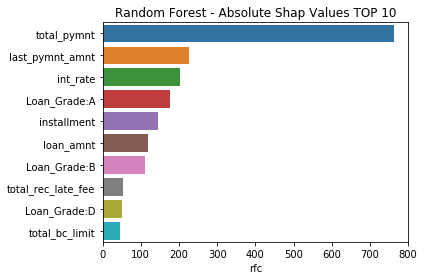

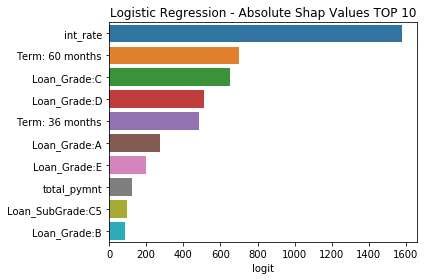

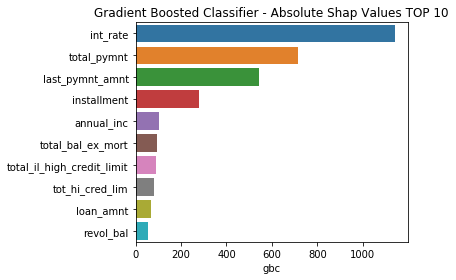

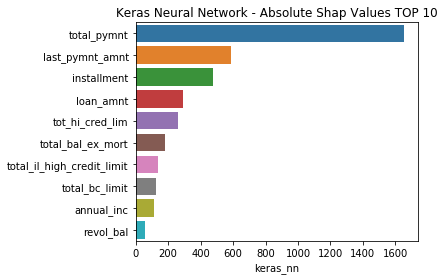

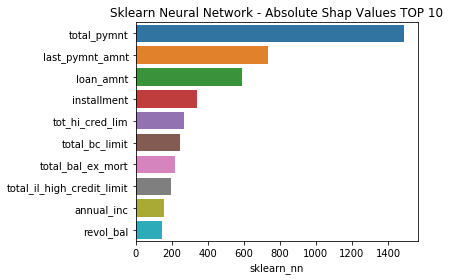

In [16]:
'''
Absolute and summation of shap values can be found @ obj/lendingclub/shap/ as csv files
The below will output the top ten ranked by absolute value, and the top and bottom 5 feats. by raw magnitude.
'''

from utils.helpful_util import display_abs_shapvalues, display_shapvalues

display_abs_shapvalues(shapvalues=shap_values,
                       features=features,
                       num_features=10)

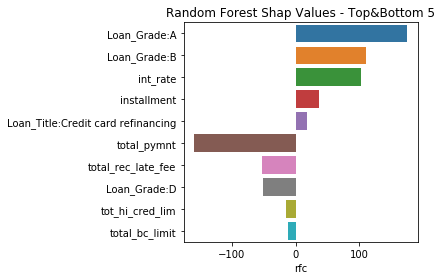

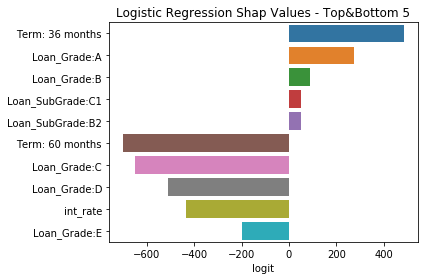

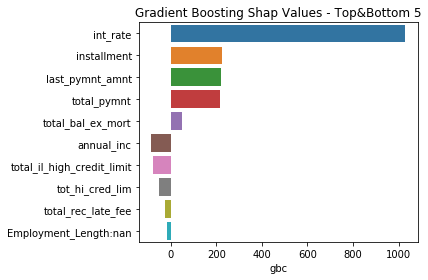

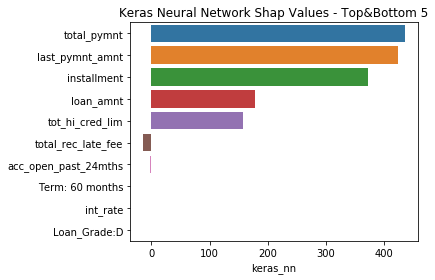

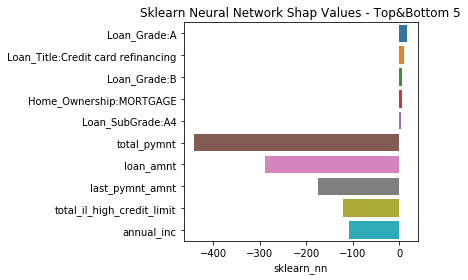

In [17]:
'''
For keras neural network below...
I believe we see the magnitudes in the negative direction lower here due to the low base value. Again,
Base value was computed as the probability of class 1 over the median of the columns in the train data.
This ended up being a predicted probability of ~6%. 
Because Shap is pred - baseline & our baseline is so low, it makes sense that there would be more push toward a more positive
model output - Atleast, that's what I'm thinking

'''

display_shapvalues(shapvalues=shap_values, features=features, n=10)

## Working with Integrated Gradients

interactive(children=(Dropdown(description='features', options=('loan_amnt', 'int_rate', 'installment', 'annua…

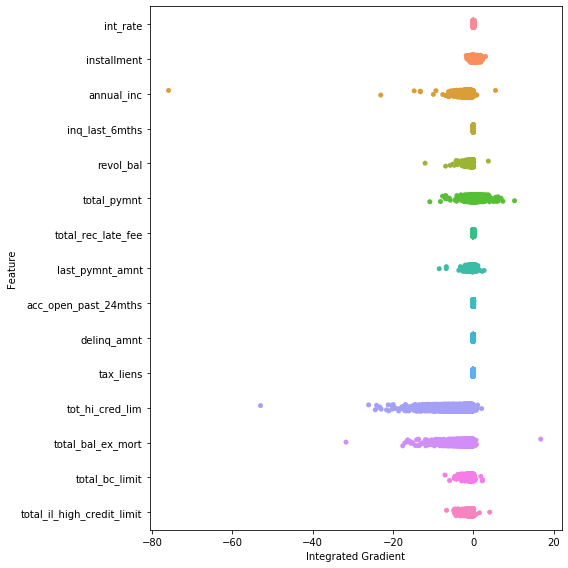

In [18]:
#Show integrated gradients of only continuous features
rcParams['figure.figsize'] = 8, 8
keras_ig_df = load_obj('data_objects/keras_ig_df')
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
@interact
def shap_plot_summary_int(features=list(keras_ig_df[continuous].columns),
                              theme=list(cf.themes.THEMES.keys()),
                              colorscale=list(cf.colors._scales_names.keys())):
        try:

            return keras_ig_df[features].iplot(
                kind='area',
                theme=theme,
                xTitle='Observation',
                yTitle='Integrated Grad Value',
                title='Integrated Grad Value vs Observation, Feature: {}'.format(
                    features),
                colorscale=colorscale)
        except:
            print("Plotly Account Needed on external devices")



df_sns = keras_ig_df.iloc[:, -15:].melt(var_name='groups', value_name='vals')
sns.stripplot(x="vals", y="groups", data=df_sns)
plt.xlabel('Integrated Gradient')
plt.ylabel('Feature')
plt.show()

## DeepExplain - Shapley/Saliency maps/Gradient * Input

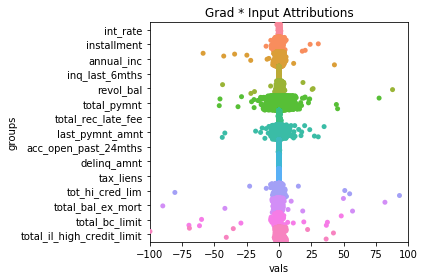

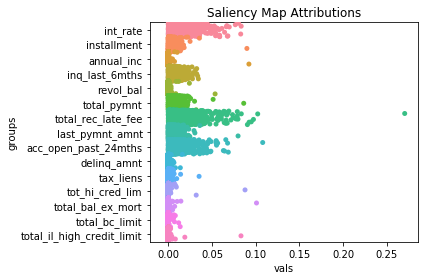

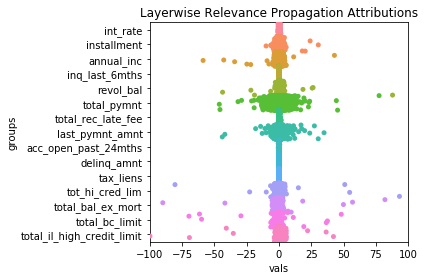

In [51]:
#Removed dependency on DeepExplain.
#Can pip install -e git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain
attributions_gradin = load_obj('attributions_gradin')
attributions_sal = load_obj('attributions_sal')
attributions_elrp = load_obj('attributions_elrp')
attributions_sv = load_obj('attributions_sv')

#Load attributions and show columnwise dotplots. Note that we are only looking at the tail 14 features here.
deep_df = pd.DataFrame(attributions_gradin, columns=features)
deep_df = deep_df.iloc[:, -15:].melt(var_name='groups', value_name='vals')
ax = sns.stripplot(x="vals", y="groups", data=deep_df, jitter=.5)
plt.xlim(-100, 100)
plt.title('Grad * Input Attributions')
plt.show()


deep_df = pd.DataFrame(attributions_sal, columns=features)
deep_df = deep_df.iloc[:, -15:].melt(var_name='groups', value_name='vals')
ax = sns.stripplot(x="vals", y="groups", data=deep_df, jitter=.5)
plt.title('Saliency Map Attributions')
plt.show()

deep_df = pd.DataFrame(attributions_elrp, columns=features)
deep_df = deep_df.iloc[:, -15:].melt(var_name='groups', value_name='vals')
ax = sns.stripplot(x="vals", y="groups", data=deep_df, jitter=.5)
plt.xlim(-100, 100)
plt.title('Layerwise Relevance Propagation Attributions')
plt.show()


## GAM

## GAM Attributions On Full Keras ANN Shap Values

				Showing GAM Explanation #1


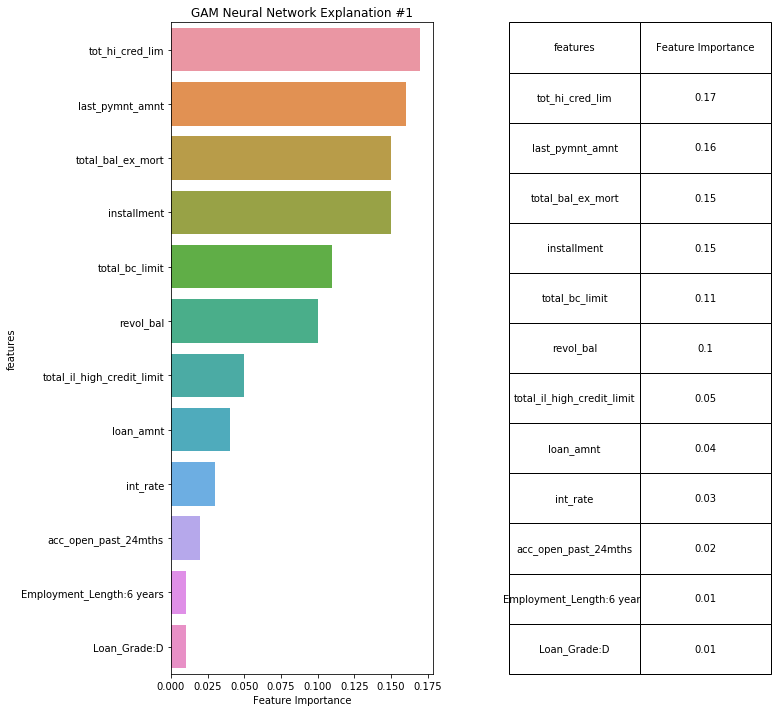

----------------------------------------------------------------------------------------------------
				Showing GAM Explanation #2


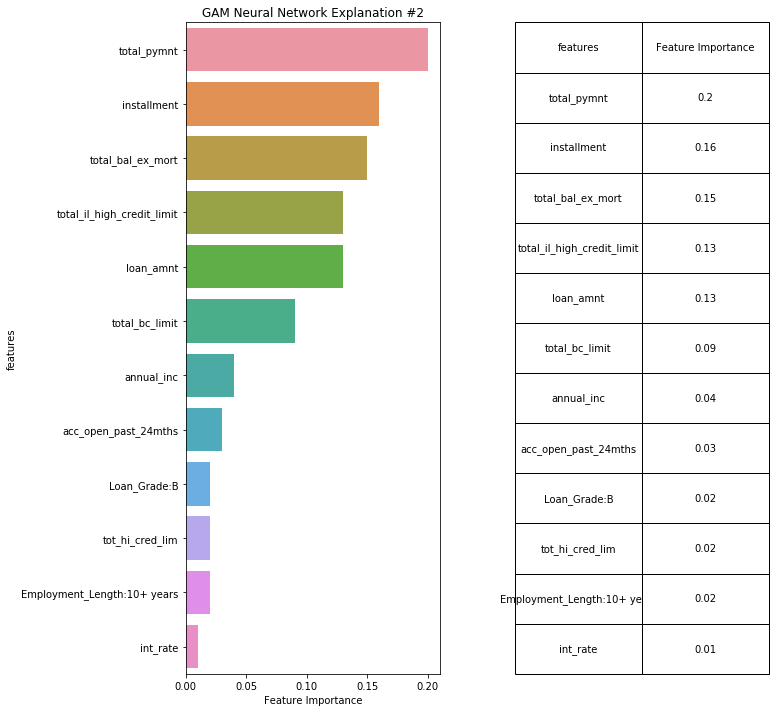

----------------------------------------------------------------------------------------------------


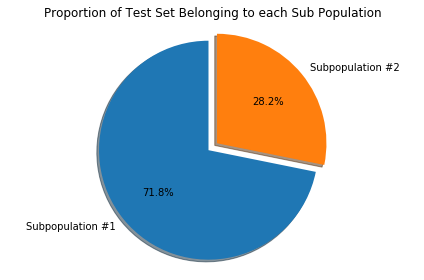

In [52]:
'''
Reload GAM objects + Plot all feature importance metrics for each of the explanations.
Plot shows: Top 2 Clusters and their top features

https://github.com/capitalone/global-attribution-mapping

Below is Gam Attribution on the whole entire test set's shap values w/ k = 2
'''
from gam.gam.gam import GAM

def shap_to_csv(model, file_name):
    local = pd.DataFrame(shap_values[str(type(model))],
                         columns=features)  #Sample 1000 rows of shap values
    local.to_csv('obj/lendingclub/gam/{}_local.csv'.format(file_name),
                 index=False)
    
from IPython.display import display, HTML

gam_keras = load_obj('/gam/gam_keras')

for i in range(len(gam_keras.explanations)):
    print('\t\t\t\tShowing GAM Explanation #{}'.format(i + 1))
    gam_nn_df = pd.DataFrame(gam_keras.explanations[i],
                             columns=['features', 'Feature Importance'
                                      ]).sort_values(by='Feature Importance',
                                                     ascending=False)
    gam_nn_df = gam_nn_df[gam_nn_df['Feature Importance'] > 0]
    gam_nn_df['Feature Importance'] = np.round(gam_nn_df['Feature Importance'],
                                               2)
    #print(gam_nn_df.to_string())
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(121)
    sns.barplot(gam_nn_df['Feature Importance'], gam_nn_df['features'])
    ax2 = fig.add_subplot(122)
    font_size = 10
    bbox = [0.25, 0, 1, 1]
    ax2.axis('off')
    mpl_table = ax2.table(cellText=gam_nn_df.values,
                          bbox=bbox,
                          colLabels=gam_nn_df.columns, colWidths=[.5 for x in gam_nn_df.columns], cellLoc='center')
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    ax1.set_title('GAM Neural Network Explanation #{}'.format(i + 1))
    plt.tight_layout(rect=[0.5, 0.1, 1.6, .95])
    plt.show()
    print('-' * 100)

labels = ['Subpopulation #1', 'Subpopulation #2']
sizes = [
    gam_keras.subpopulation_sizes[0] / sum(gam_keras.subpopulation_sizes) *
    100,
    gam_keras.subpopulation_sizes[1] / sum(gam_keras.subpopulation_sizes) * 100
]
explode = (0.1, 0.0)
fig1, ax1 = plt.subplots()

ax1.pie(sizes,
        explode=explode,
        labels=labels,
        autopct='%1.1f%%',
        shadow=True,
        startangle=90)
ax1.axis('equal')
plt.title('Proportion of Test Set Belonging to each Sub Population')
plt.tight_layout(rect=[0.11, 0.1, 1.6, .95])
plt.show()

### Plots for samples of shap values based on various models

In [53]:
'''
This works for model / gam generation selection, but is really computationally expensive when you try to generate
w/ more than 200 observations. I have it set up to randomly select n sets of shap values according to the slider.


'''

import os
import time


def shap_to_csv_rev(model, num_obs, k):
    file_name = models[str(type(model))][0]
    local = pd.DataFrame(shap_values[str(type(model))],
                         columns=features).iloc[:num_obs, :]
    local.to_csv('obj/lendingclub/gam/{}_{}obs_local.csv'.format(
        file_name, num_obs),
                 index=False)
    gam_test = GAM(
        attributions_path='obj/lendingclub/gam/{}_{}obs_local.csv'.format(
            file_name, num_obs),
        k=k)
    gam_test.generate()
    os.remove('obj/lendingclub/gam/{}_{}obs_local.csv'.format(
        file_name, num_obs))
    return gam_test

@interact
def display_gam_feat_importance(
        models=widgets.ToggleButtons(
            options=[
                'keras neural network', 'logistic regression',
                'gradient boosted trees', 'random forest'
            ],
            description='Models:',
            disabled=False,
            button_style='',  # 'success', 'info', 'warning', 'danger' or ''
            tooltips=[
                'keras sequential neural network', 'sklearn logit',
                'sklearn gradient boosted classifier', 'sklearn random forest'
            ]),
        num_obs=list(range(25, 500, 25)),
        clusters=widgets.FloatText(value=2,
                                   description='# of clusters:',
                                   disabled=False)):
    gam = shap_to_csv_rev(model=model_dict_2[models],
                          num_obs=num_obs,
                          k=clusters)
    for i in range(len(gam_keras.explanations)):
        print('\t\t\t\tShowing GAM Explanation #{}'.format(i + 1))
        gam_nn_df = pd.DataFrame(gam_keras.explanations[i],
                                 columns=['features', 'Feature Importance'
                                          ]).sort_values(by='Feature Importance',
                                                         ascending=False)
        gam_nn_df = gam_nn_df[gam_nn_df['Feature Importance'] > 0]
        gam_nn_df['Feature Importance'] = np.round(gam_nn_df['Feature Importance'],
                                                   2)
        #print(gam_nn_df.to_string())
        fig = plt.figure(figsize=(10, 10))
        ax1 = fig.add_subplot(121)
        sns.barplot(gam_nn_df['Feature Importance'], gam_nn_df['features'])
        ax2 = fig.add_subplot(122)
        font_size = 10
        bbox = [0.25, 0, 1, 1]
        ax2.axis('off')
        mpl_table = ax2.table(cellText=gam_nn_df.values,
                              bbox=bbox,
                              colLabels=gam_nn_df.columns, colWidths=[.5 for x in gam_nn_df.columns], cellLoc='center')
        mpl_table.auto_set_font_size(False)
        mpl_table.set_fontsize(font_size)
        ax1.set_title('GAM Neural Network Explanation #{}'.format(i + 1))
        plt.tight_layout(rect=[0.5, 0.1, 1.6, .95])
        plt.show()
        print('-' * 100)


interactive(children=(ToggleButtons(description='Models:', options=('keras neural network', 'logistic regressi…

In [58]:
'''

Teseting other attr. values
'''


def att_to_csv_rev(df, num_obs, k):
    file_name = 'integrated_gradients'
    local = non_shap_attributions[df].iloc[:num_obs, :]
    local.to_csv('obj/lendingclub/gam/{}_{}obs_local.csv'.format(
        file_name, num_obs),
                 index=False)
    gam_test = GAM(
        attributions_path='obj/lendingclub/gam/{}_{}obs_local.csv'.format(
            file_name, num_obs),
        k=k)
    gam_test.generate()
    os.remove('obj/lendingclub/gam/{}_{}obs_local.csv'.format(
        file_name, num_obs))
    return gam_test


import os

gradin = pd.DataFrame(load_obj('attributions_gradin'), columns=features)
saliency = pd.DataFrame(load_obj('attributions_sal'), columns=features)
layerwise = pd.DataFrame(load_obj('attributions_elrp'), columns=features)

non_shap_attributions = {
    'grad * input': gradin,
    'saliency maps': saliency,
    'layerwise relevance propogation': layerwise,
    'integrated gradients': keras_ig_df
}


@interact
def display_gam_feat_importance(attributions=[
        'grad * input', 'saliency maps', 'layerwise relevance propogation',
        'integrated gradients'
],
                                num_obs=list(range(25, 500, 25)),
                                clusters=widgets.FloatText(
                                    value=2,
                                    description='# of clusters:',
                                    disabled=False)):

    gam = att_to_csv_rev(df=attributions, num_obs=num_obs, k=clusters)
    for i in range(len(gam.explanations)):

        print('\t\t\t\tShowing GAM Explanation #{}'.format(i + 1))
        gam_nn_df = pd.DataFrame(gam.explanations[i],
                                 columns=['features',
                                          'Feature Importance']).sort_values(
                                              by='Feature Importance',
                                              ascending=False)
        gam_nn_df = gam_nn_df[gam_nn_df['Feature Importance'] > 0]
        gam_nn_df['Feature Importance'] = np.round(
            gam_nn_df['Feature Importance'], 2)
        #print(gam_nn_df.to_string())
        fig = plt.figure(figsize=(10, 10))
        ax1 = fig.add_subplot(121)
        sns.barplot(gam_nn_df['Feature Importance'], gam_nn_df['features'])
        ax2 = fig.add_subplot(122)
        font_size = 10
        bbox = [0, 0, 1, 1]
        ax2.axis('off')
        mpl_table = ax2.table(cellText=gam_nn_df.values,
                              bbox=bbox,
                              colLabels=gam_nn_df.columns)
        mpl_table.auto_set_font_size(False)
        mpl_table.set_fontsize(font_size)
        ax1.set_title('GAM Neural Network Explanation #{}'.format(i + 1))
        plt.tight_layout(rect=[2.11, 2.0, 2.0, 2.0])
        plt.show()
        print('-' * 100)

interactive(children=(Dropdown(description='attributions', options=('grad * input', 'saliency maps', 'layerwis…